## 各エンドポイントの説明

In [1]:
#新たに作成したモジュールなどをimport
import sys
import json
import requests
import os
import pandas as pd
sys.path.append("../src")

#host_name = "http://localhost:8081"

#webアプリを使用する場合は以下を使用する
host_name = "http://13.208.189.76:8081"

## データベースをリセットする

データベースの内容をすべて削除する。settingは初期設定に戻る。

In [ ]:
url = host_name + "/reset_db"
res = requests.get(url)

print(res.content)

InvalidSchema: No connection adapters were found for '13.208.189.76:8081/reset_db'

## 使用するデータを取得

In [ ]:
# URL to the Titanic dataset
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
# Read data from the URL
raw_data = pd.read_csv(url)

In [ ]:
raw_data[0:2]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


## データフレームを辞書型に変換する

空白があるデータなどは除外する(pipeline推論では欠損したデータも入力可能)

入力形式は dict型　のため、事前に変換する必要がある。

In [ ]:
def dataframe_to_dict(df:pd.DataFrame, mode:str='neutral'):
    try:
        result_list = []
        df = df[['Survived','Pclass','Sex','Age','Fare']]
        if mode=='sex_to_num':
            df.loc[:,'Sex'] = df.loc[:,'Sex'].map({'male': 0, 'female': 1})
        df = df.dropna()
        df.loc[:,'Age'] = df.loc[:,'Age'].astype(int)
        for i in range(len(df)):
            row = df.iloc[i]
            if row.isna().any():
                break  # NaNが見つかったらループを抜ける
            result_list.append(row.to_dict())
        return result_list
    except KeyError as e:
        print(e)
        return "正しいデータ形式ではありません。"
    except Exception as e:
        print(e)

In [ ]:
#from utils import dataframe_to_dict

success_result_dict = dataframe_to_dict(raw_data[0:2])
print('~~~~成功例~~~~')
print(success_result_dict)

#['Survived', 'Pclass', 'Sex', 'Age', 'Fare']の項目が揃っていないデータはエラーを返す
print('~~~~失敗例~~~~~')
false_result_dict = dataframe_to_dict(raw_data[0:2]['Name'])
print(false_result_dict)

~~~~成功例~~~~
[{'Survived': 0, 'Pclass': 3, 'Sex': 'male', 'Age': 22.0, 'Fare': 7.25}, {'Survived': 1, 'Pclass': 1, 'Sex': 'female', 'Age': 38.0, 'Fare': 71.2833}]
~~~~失敗例~~~~~
"None of [Index(['Survived', 'Pclass', 'Sex', 'Age', 'Fare'], dtype='object')] are in the [index]"
正しいデータ形式ではありません。


## データベースにデータの登録を行う

返り値はデータベースへの登録がうまくいったかどうか

In [ ]:
#データを辞書型のリストに変換する
data_dict = dataframe_to_dict(raw_data[0:10],mode='sex_to_num')

#データをデータベースに登録する
url = host_name + "/upload_data"
res = requests.post(url, json=data_dict)

print(res.content)

b'{"transaction_result":"success"}'


## データベースからデータを取得する

end_index に　-1を指定すると全データを取得する

In [2]:
#DBからデータを取得する
url = host_name + "/get_data"
data_index={'start_index':1000,'end_index':-1}#取得するindexの範囲を指定する
res = requests.post(url, json=data_index)

#resはバイナリデータで返される, decodeで文字列に変換
#その後、{}で囲まれた部分を、json.loads()で辞書型データに変換
data_list = json.loads(res.content.decode('utf-8'))
df = pd.DataFrame(data_list)
df

,upload_date,pclass,data_id,age,sex,survived,fare
0,2024-05-26,3,1,22.0,0,0,7.2500
1,2024-05-26,1,2,38.0,1,1,71.2833
2,2024-05-26,3,3,26.0,1,1,7.9250
3,2024-05-26,1,4,35.0,1,1,53.1000
4,2024-05-26,3,5,35.0,0,0,8.0500
5,2024-05-26,1,6,54.0,0,0,51.8625
6,2024-05-26,3,7,2.0,0,0,21.0750
7,2024-05-26,3,8,27.0,1,1,11.1333
8,2024-05-26,2,9,14.0,1,1,30.0708
9,2024-05-26,3,10,35.0,0,0,8.0500


## 新しいモデルの作成

指定したindexの範囲のデータを利用してトレーニングを行う

In [ ]:
data = {'start_index':1000, 'end_index':5000, 'my_model_name':'new_test_2'}#トレーニングに使うindexの範囲と名前を指定する
url = host_name + "/train_new_model"
res = requests.post(url, json=data)

data_list = json.loads(res.content.decode('utf-8'))
print(data_list)

{'transaction_result': 'success'}


## データベースからモデルの情報を取得する

model_id に -1を指定するとすべてのモデルデータが取得できる

特定のインデックスを指定して検索することも可能。version_id_2 まで指定できる。

In [ ]:
data = {'version_id_1' : -1}
url = host_name + "/get_model"
res = requests.post(url, json=data)

data_list = json.loads(res.content.decode('utf-8'))
df = pd.DataFrame(data_list[0])
df

,model_version_id,pclass_coef,age_coef,training_iteration,sex_coef,training_date,my_model_name,fare_coef
0,743,-0.916433,-0.014797,36,1.64417,2024-05-26,new_test_2,-0.017794


## モデルを評価する

version_id -> ２つのidを指定して、modelの比較ができる。idの指定は１つでも可能。

start(end)_index -> 指定した範囲のデータに対しての推論結果などを表示する

アウトプットは、python_backend/outputsに、画像データとして入力される。

In [ ]:
data = {'version_id_1' : 911,'version_id_2' : 923,'start_index':3008, 'end_index':3085}
url = host_name + "/evaluate_model"
res = requests.post(url, json=data)

result = json.loads(res.content.decode('utf-8'))
print(result)

{'result': '結果の出力に成功しました。'}


## pipline推論の設定を確認・変更する
Noneにしておくと、その項目は変更しない。また、変更がない場合も更新しない。

### 各変数の説明
best_model_id: pipline推論で用いる最初のモデルを指定

num_for_result_check: モデルのhealth_checkの際に直近の何個データをさかのぼってaccuracy(f1-score)を計算するか

threshold_percentage: health_check 不合格の基準となるスコアを設定する

num_for_re_training: 不合格になった場合に、何個のデータを使って再びトレーニングするか

In [ ]:
setting_dict = {
    #'setting_id':None,
    'best_model_id': None,
    'num_for_result_check':30,
    'threshold_percentage':0.8,#0~1で指定する
    'num_for_re_training':20
}

#設定を確認する
url = host_name + "/setting"
res = requests.post(url, json=setting_dict)

res = json.loads(res.content.decode('utf-8'))
print(res)

setting_dict = res['setting']

{'result': 'settingの更新はありません', 'setting': {'setting_id': 564, 'best_model_id': 884, 'num_for_result_check': 30, 'check_type': 'accuracy', 'threshold_percentage': 0.8, 'num_for_re_training': 20}}


## 継続的な学習(pipeline推論)を実施する

データが連続して入力された際に、継続的な改善を行う。

In [ ]:
#データを辞書型のリストに変換する
data_dict = dataframe_to_dict(raw_data[0:100],mode='sex_to_num')

#データをデータベースに登録する
url = host_name + "/pipeline"
res = requests.post(url, json=data_dict)

Health_checkを評価したログを出力

new_accuracyは、新しく作成したモデルの直近のデータに対しての正解率。

In [ ]:
data_list = json.loads(res.content.decode('utf-8'))
df = pd.DataFrame(data_list['health_check_result'])
pd.set_option('display.max_rows', None)
df

,health_check_id,model_version_id,data_id,setting_id,accuracy_score,f1_score,NG_decision,new_accuracy_score,new_f1_score
0,2601,884,3008,564,0.833333,0.705882,False,NaN,NaN
1,2602,884,3009,564,0.833333,0.705882,False,NaN,NaN
2,2603,884,3010,564,0.800000,0.666667,False,NaN,NaN
3,2604,884,3011,564,0.833333,0.736842,False,NaN,NaN
4,2605,884,3012,564,0.833333,0.736842,False,NaN,NaN
5,2606,884,3013,564,0.833333,0.736842,False,NaN,NaN
6,2607,884,3014,564,0.833333,0.736842,False,NaN,NaN
7,2608,884,3015,564,0.800000,0.700000,False,NaN,NaN
8,2609,884,3016,564,0.800000,0.727273,False,NaN,NaN
9,2610,884,3017,564,0.833333,0.782609,False,NaN,NaN


## 結論を図にする

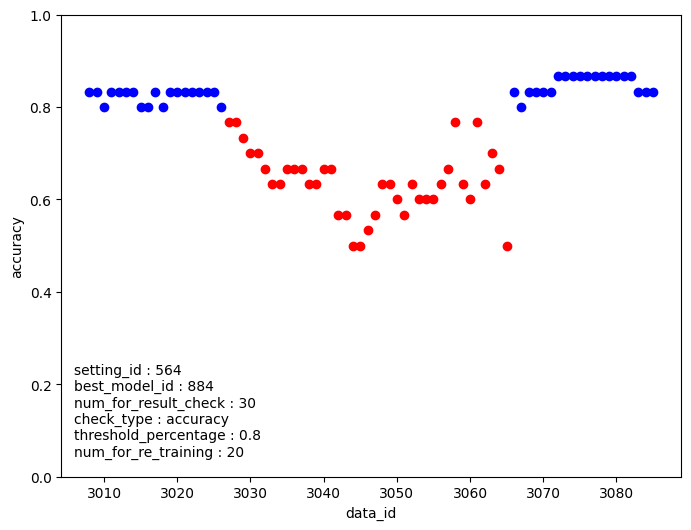

In [ ]:
import matplotlib.pyplot as plt

text = ""

for i in setting_dict.keys():
    tmp = i + " : " + str(setting_dict[i]) + "\n"
    text += tmp

fig = plt.figure(figsize=(8, 6))

div_x_list = [[], []]
div_y_list = [[], []]

for i in range(len(df)):

    if df.iloc[i]['NG_decision'] == False:
        div = 0
    else:
        div = 1

    div_x_list[div].append(df.iloc[i]['data_id'])
    div_y_list[div].append(df.iloc[i]['accuracy_score'])

ax = fig.add_subplot(1,1,1)
ax.set_xlabel('data_id')
ax.set_ylabel(setting_dict['check_type'])
ax.scatter(div_x_list[0], div_y_list[0], color='blue')
ax.scatter(div_x_list[1], div_y_list[1], color='red')
ax.text(0.02, 0.01, text, transform=ax.transAxes)
ax.set_ylim(0, 1)

fig.show()

In [ ]:
df = pd.DataFrame(data_list['prediction_result'])
df

,Survived,Pclass,Sex,Age,Fare,result
0,0,3,0,22.0,7.2500,0
1,1,1,1,38.0,71.2833,1
2,1,3,1,26.0,7.9250,1
3,1,1,1,35.0,53.1000,1
4,0,3,0,35.0,8.0500,0
...,...,...,...,...,...,...
73,0,3,0,59.0,7.2500,0
74,0,1,0,71.0,34.6542,0
75,1,1,0,23.0,63.3583,0
76,1,2,1,34.0,23.0000,1
